In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Levenshtein
import seaborn as sns

In [33]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [3]:
from pathlib import Path
import sys

main_path = str(Path().resolve().parent)
sys.path.append(main_path)

In [4]:
# carregando as funções de preprocessamento nlp do notebook de
# análise de produto, essas funções foram adicionadas nesse modulo
from src import nlp_preprocessing

# Carregando os dados

Carregando os dados de queries

In [5]:
df = pd.read_pickle("../data/train_query.pickle")
df.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
423,14710443,15837,trocador de comoda,1,3,trocador de comoda reto,moveis trocador comoda enxoval henrique,2017-08-24 15:59:44,130.50000,609.0,1,1,126,7,Bebê
11878,5013802,303463,necessaire box futebol,1,19,Necessaire box masculina personalizada Dia dos...,dia pais,2019-07-21 16:07:32,28.36000,81.0,1,8,98,15,Lembrancinhas
34479,8000979,3637678,lembrancinhas de eva para igreja,1,33,Mini Porta-retrato com mensagem Louvarei ao Se...,festividades religiosas/igreja,2018-09-08 18:38:22,12.15000,8.0,1,10,355,1,Lembrancinhas
8489,4875844,5965170,almofada para cadeira,1,0,Almofada Para Cadeira De Balanço Do Papai,almofada cadeira balanco,2018-05-13 17:55:56,169.81001,6.0,1,1,186,0,Decoração
31176,6285211,7327649,quanto custa caneca personalizada,1,0,Caneca personalizada,caneca personalizada caneca lembrancinhas mono...,2017-08-20 18:59:02,17.50000,9.0,1,4,733,0,Lembrancinhas


In [6]:
df["position"].describe()

count    26912.000000
mean        16.906622
std         11.620276
min          0.000000
25%          6.000000
50%         16.000000
75%         27.000000
max         38.000000
Name: position, dtype: float64

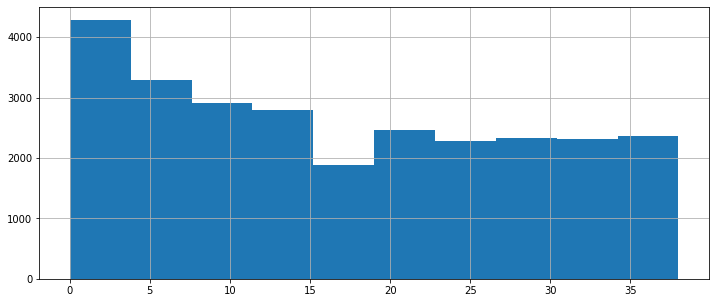

In [7]:
df["position"].hist(figsize=(12, 5))
plt.show()

Nós temos mais queries nas posições iniciais porém a distribuição pode ser considerada uniforme para a posição maior que 10.

In [8]:
(df.groupby("query").
 apply(lambda x: x["position"].nunique()).
 to_frame("unique_position").
 join(df["query"].
      value_counts().
      rename("freq")).
 describe())

,unique_position,freq
count,5866.000000,5866.000000
mean,4.114899,4.587794
std,4.535971,6.815524
min,1.000000,1.000000
25%,1.000000,1.000000
50%,3.000000,3.000000
75%,5.000000,5.000000
max,39.000000,106.000000


Apesar da distribuição das posições ser uniforme para as 

# Mapeando as relações

In [9]:
df[["view_counts", "order_counts"]].describe()

,view_counts,order_counts
count,26912.000000,26912.000000
mean,544.630239,12.965034
std,1439.207487,45.933669
min,1.000000,0.000000
25%,118.000000,0.000000
50%,243.000000,0.000000
75%,519.000000,14.000000
max,45010.000000,2460.000000


In [10]:
df["recommend"] = df["position"] < 10
df["recommend"].value_counts()

False    17871
True      9041
Name: recommend, dtype: int64

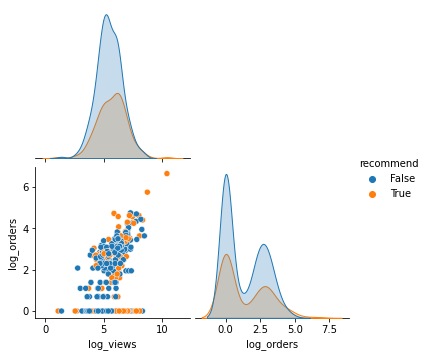

In [11]:
cols = ['log_views', 'log_orders']
df["log_views"] = np.log(df["view_counts"])
df["log_orders"] = np.log(df["order_counts"].add(1))

sns.pairplot(df[cols + ["recommend"]].sample(500),
             hue="recommend",
             corner=True)
plt.show()

# Modelando posição

## Distancia de Edição

In [12]:
def relative_levenshtein(str1, str2):
    dist = Levenshtein.distance(str1, str2)
    normalizer = max(len(str1), len(str2))
    return dist / normalizer

In [13]:
df["cleaned_title"] = df["title"].apply(nlp_preprocessing.preprocess_txt)
df["cleaned_query"] = df["query"].apply(nlp_preprocessing.preprocess_txt)
df["dist"] = df.apply(lambda x: relative_levenshtein(x["cleaned_query"], x["cleaned_title"]), axis=1)

In [14]:
df["title_size"] = df["cleaned_title"].str.split().apply(len)
df["query_size"] = df["cleaned_query"].str.split().apply(len)
df["size_diff"] = df["title_size"] - df["query_size"]

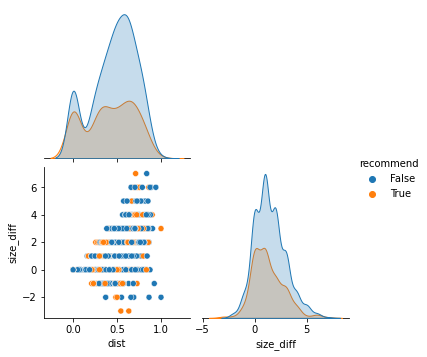

In [15]:
cols = ["dist", "size_diff"]
sns.pairplot(df[cols + ["recommend"]].sample(1000),
             hue="recommend",
             corner=True)
plt.show()

# Distância de cosseno

In [16]:
tfidf_vec = TfidfVectorizer()
tfidf_vec.fit(df["cleaned_title"])

TfidfVectorizer()

In [17]:
"asdada adad".split()

['asdada', 'adad']

In [18]:
title_dict = tfidf_vec.get_feature_names_out()
title_dict

array(['aaj', 'aba', 'abacax', ..., 'zootecn', 'zpagett', 'zum'],
      dtype=object)

In [19]:
def check_dictionary_coverage(cleaned_query, dict_data=title_dict):
    query_tokens_set = set(cleaned_query.split())
    dict_data_set = set(dict_data)
    len_query_in_dict = len(query_tokens_set.intersection(dict_data_set))
    try:
        return len_query_in_dict / len(query_tokens_set)
    except ZeroDivisionError:
        return np.nan

In [20]:
df["query_in_title"] = df["cleaned_query"].apply(check_dictionary_coverage)
df["query_in_title"].describe()

count    26907.000000
mean         0.989391
std          0.072134
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: query_in_title, dtype: float64

In [21]:
def tfidf_toarray(data, tfidf_vec=tfidf_vec):
    return (np.asarray(tfidf_vec.
                       transform(data).
                       todense())[0].
            reshape(1, -1))

def compute_consine_distance(query, title):
    query_vec = tfidf_toarray([query])
    title_vec = tfidf_toarray([title])
    return cosine_distances(query_vec, title_vec)[0][0]

In [22]:
df["cos_dist"] = df.apply(lambda x:
                          compute_consine_distance(x["cleaned_query"],
                                                   x["cleaned_title"]),
                          axis=1)

In [23]:
df["cos_dist"].describe()

count    26912.000000
mean         0.350657
std          0.253231
min          0.000000
25%          0.161240
50%          0.335111
75%          0.508176
max          1.000000
Name: cos_dist, dtype: float64

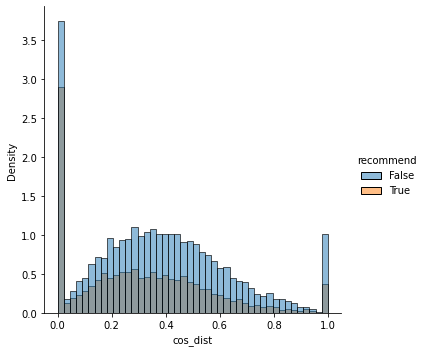

In [25]:
sns.displot(df, x="cos_dist", hue="recommend", stat="density")
plt.show()

In [26]:
df.dropna(inplace=True)

In [27]:
cols = ['price', 'size_diff', 'dist', 'cos_dist', 'query_in_title']

In [50]:
def test_data_modeling(X_train: pd.DataFrame, y_train: pd.Series, model, scoring) -> None:
    """Gera várias visualizações para avaliar o desempenho do treinamento

    Args:
        X_train (pd.DataFrame): _description_
        y_train (pd.Series): _description_
        model (sklearn.model): _description_
    """
    
    # treinando o modelo com validação cruzada
    cv_score = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1,
                               scoring=scoring)
    mean_score = cv_score.mean()
    std_score = cv_score.std()
    # treinando o modelo
    model.fit(X_train, y_train)
    # plotando a importância dos parâmetros
    importances = pd.Series(model.coef_[0], index=X_train.columns)
    importances.sort_values().plot(kind="barh")
    plt.show()
    
    print({"cv_mean_score": mean_score,
           "cv_std_score": std_score})

In [46]:
model = LogisticRegression()
y = "recommend"
scoring = "accuracy"

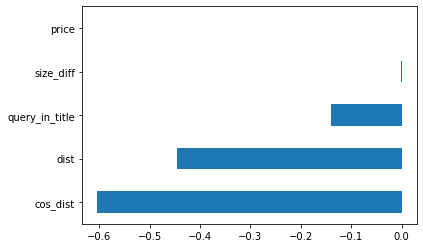

{'cv_mean_score': 0.6640651131460178, 'cv_std_score': 6.785924463587982e-05}


In [51]:
test_data_modeling(df[cols], df[y], model, scoring)

In [55]:
model = LinearRegression()
y = "position"
scoring = "neg_mean_absolute_error"

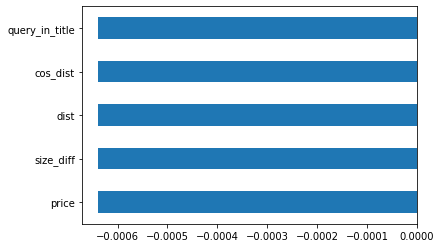

{'cv_mean_score': -9.997298233515021, 'cv_std_score': 0.12607732243613295}


In [58]:
test_data_modeling(df[cols], df[y], model, scoring)